In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from tabulate import tabulate

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, precision_score, accuracy_score, plot_roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter('ignore')


In [401]:
# Get proper file path separator for current OS
s = os.path.sep

In [402]:
# Import original data
cancer = pd.read_csv("D:" + s + "2022 Spring" + s + "ISYE7406" + s + "HW" + s + "HW5" + s + "breast cancer data.csv")

In [403]:
# Add new column, diag_01, as the target column
# diag_01 = 1 if diagnosis = M; diag_01 = 0 if diagnosis = B
cancer['diag_01'] = (cancer['diagnosis'] == 'M').astype(int)

In [404]:
# Train-test split, keep the origianl ratio of two classes
# Use 30% as testing set. 
test = cancer.groupby('diag_01', group_keys = False).apply(lambda x: x.sample(frac = 0.25, random_state = 1))
train = cancer.drop(labels = test.index)

# Exploratory Data Analysis on Training Set

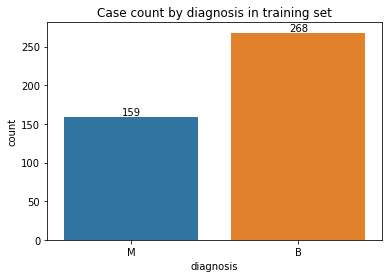

In [405]:
# Basic case count
fig = sns.countplot(x = 'diagnosis', data = train)
plt.bar_label(fig.containers[0])
plt.title('Case count by diagnosis in training set' )
plt.show()

In [406]:
# Write a function to do swarmp plot
def do_swarmplot(df, id_var):
    data = pd.melt(df, id_vars = id_var, var_name = 'features', value_name = 'value')
    sns.swarmplot(x = 'features', y = 'value', hue = id_var, data = data, size = 3)
    plt.xticks(rotation = 90)
    plt.title('Class distribution within each feature')
    plt.legend(loc='best',markerscale=0.5)
    plt.show()

In [407]:
# Standardize the data for visualization
cols_all = train.columns.to_list()
cols_to_pass = ['id', 'diagnosis', 'diag_01']
cols_to_std = [col for col in cols_all if col not in cols_to_pass]

In [408]:
train_std = (train[cols_to_std] - train[cols_to_std].mean()) / train[cols_to_std].std()


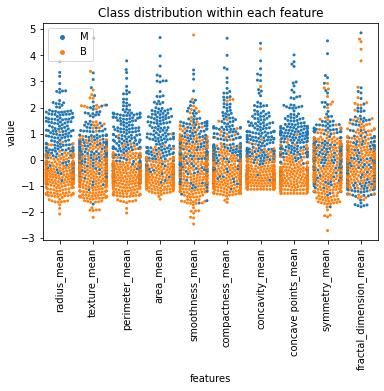

In [409]:
# Plot each features based on diagnosis
do_swarmplot(pd.concat([train['diagnosis'], train_std.iloc[:, 0:10]], axis = 1), 'diagnosis')

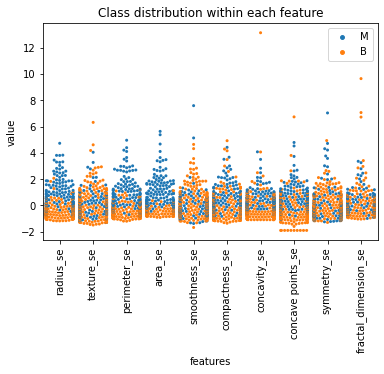

In [410]:
# Plot each features based on diagnosis
do_swarmplot(pd.concat([train['diagnosis'], train_std.iloc[:, 10:20]], axis = 1), 'diagnosis')

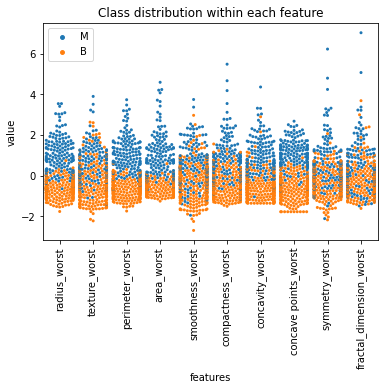

In [411]:
# Plot each features based on diagnosis
do_swarmplot(pd.concat([train['diagnosis'], train_std.iloc[:, 20:30]], axis = 1), 'diagnosis')

# Useful functions

In [412]:
# Create a function to show confusion matrix
def show_confusion_matrix(model, model_name, test_X, test_Y, pred_Y):
    
    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(test_Y, pred_Y)

    true_negatives = cf_matrix[0][0]
    false_negatives = cf_matrix[1][0]
    true_positives = cf_matrix[1][1]
    false_positives = cf_matrix[0][1]

    # Calculate classification performance
    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    # Show classification performance in a DataFrame
    accu = ['(TN+TP)/(TN+TP+FN+FP)', "{:.4f}".format(float(accuracy))]
    prec = ['TP/(TP+FP)', "{:.4f}".format(float(precision))]
    rec = ['TP/(TP+FN)', "{:.4f}".format(float(recall))]
    spec = ['TN/(TN+FP)', "{:.4f}".format(float(specificity))]
    df = pd.DataFrame({'Accuracy':accu, 'Precision':prec, 'Recall':rec, 'Specificity':spec}, index = ['Formula', 'Value'])

    print(tabulate(df, headers = 'keys', tablefmt='grid', stralign='center'))

    # Show confusion matrix
    disp = plot_confusion_matrix(model, test_X, test_Y, display_labels = ['Benign', 'Malignant'],  cmap=plt.cm.Blues)
    disp.ax_.set_title('Confusion Matrix for ' + model_name)
    plt.show()


In [413]:
# Create a function to show ROC curve
def show_ROC_curve(model, test_X, test_Y):
    
    fig, ax = plt.subplots()
    
    # Plot the ROC curve
    plot_roc_curve(model, test_X, test_Y, alpha = 0.8, ax=ax)

    # Add our Pure Chance Line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Pure Chance', alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve" )
    ax.legend(loc="lower right")

    plt.show()

    

# Baseline Model: Logistic Regression

In [414]:
# Seperate predictors and response
train_X = train.drop(['id', 'diagnosis', 'diag_01'], axis = 1)
train_Y = train['diag_01']

test_X = test.drop(['id', 'diagnosis', 'diag_01'], axis = 1)
test_Y = test['diag_01']

In [415]:
# Train a Logistic Regression model and make prediction
lg = LogisticRegression(max_iter = 10000)
lg.fit(train_X, train_Y)
lg_pred = lg.predict(test_X)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9577         |   0.9434    |   0.9434   |    0.9663     |
+---------+-----------------------+-------------+------------+---------------+


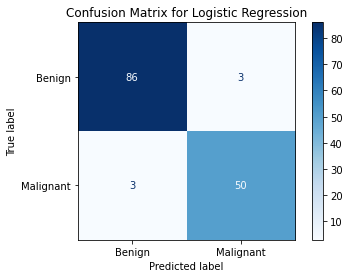

In [416]:
# Get confusion matrix
show_confusion_matrix(lg, 'Logistic Regression', test_X, test_Y, lg_pred)

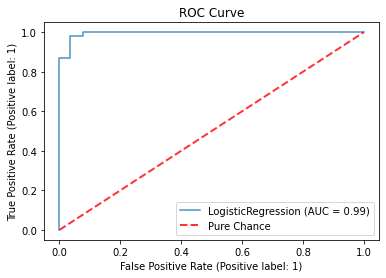

In [417]:
# Get ROC curve
show_ROC_curve(lg, test_X, test_Y)

# Model 1: Random Forrest

## Grid-search to find the best set of hyper parameters

In [418]:
# Set up for parameter tuning
rf = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = [i+1 for i in range(15)]
min_samples_leaf = [1, 5, 10] # minimum sample number that can be stored in a leaf node
grid = {'n_estimators':n_estimators, 'max_features':max_features, 'min_samples_leaf':min_samples_leaf}
cv_scheme = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2)


In [419]:
# Grid search
rf_grid_search = GridSearchCV(estimator = rf, param_grid = grid, n_jobs = -1, cv = cv_scheme, scoring='balanced_accuracy')
rf_search_result = rf_grid_search.fit(train_X, train_Y)

In [420]:
# Show the optimal parameters
print("Best accuracy score: %f using %s" % (rf_search_result.best_score_, rf_search_result.best_params_))

Best accuracy score: 0.968795 using {'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 100}


In [421]:
means = rf_search_result.cv_results_['mean_test_score']
stds = rf_search_result.cv_results_['std_test_score']
params = rf_search_result.cv_results_['params']


In [422]:
# Store the tuning result in a dataframe
rf_params = pd.DataFrame.from_dict({'score':means, 'n_estimators':[x['n_estimators'] for x in params], 'max_features':[x['max_features'] for x in params],
                       'min_samples_leaf':[x['min_samples_leaf'] for x in params]})

In [423]:
# Find the top 5 scores
rf_top5 = rf_params.sort_values(['score','n_estimators'], axis = 0, ascending = [False,True]).reset_index(drop = True).iloc[:5]

In [424]:
# Show top 5 scores
print(tabulate(rf_top5, headers = 'keys', tablefmt='grid', stralign='center'))

+----+----------+----------------+----------------+--------------------+
|    |    score |   n_estimators |   max_features |   min_samples_leaf |
+====+==========+================+================+====================+
|  0 | 0.968795 |            100 |              8 |                  1 |
+----+----------+----------------+----------------+--------------------+
|  1 | 0.961271 |           1000 |              8 |                  1 |
+----+----------+----------------+----------------+--------------------+
|  2 | 0.961271 |           1000 |             10 |                  1 |
+----+----------+----------------+----------------+--------------------+
|  3 | 0.960693 |             10 |              3 |                  1 |
+----+----------+----------------+----------------+--------------------+
|  4 | 0.960693 |            100 |             11 |                  1 |
+----+----------+----------------+----------------+--------------------+


In [425]:
# Use the optimal parameters to train model and make predictions
optimal_rf = RandomForestClassifier(n_estimators = 100, max_features = 8, min_samples_leaf = 1, random_state = 7406)
optimal_rf.fit(train_X, train_Y)
rf_pred = optimal_rf.predict(test_X)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9718         |   0.9804    |   0.9434   |    0.9888     |
+---------+-----------------------+-------------+------------+---------------+


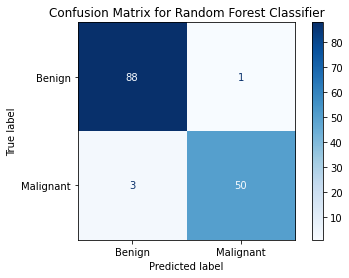

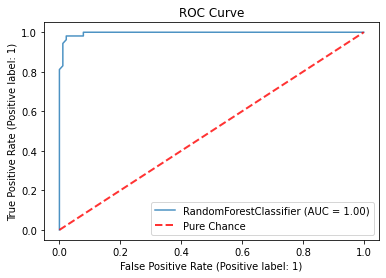

In [426]:
# Show the performance of Random Forest
show_confusion_matrix(optimal_rf, 'Random Forest Classifier', test_X, test_Y, rf_pred)
show_ROC_curve(optimal_rf, test_X, test_Y)

# Model 2: Boosting, Light GBM Classifier

## Grid search to find optimal parameters

In [427]:
lgbm = LGBMClassifier()

n_estimators = [10, 100, 500, 1000]
max_depth = [-1] + [i+1 for i in range(10)]
learning_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1]
boosting_type = ['gbdt', 'dart', 'goss', 'rf']

lgbm_grid = {'n_estimators':n_estimators, 'max_depth':max_depth, 'learning_rate':learning_rate, 'boosting_type':boosting_type}
lgbm_cv_scheme = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 3)

In [428]:
lgbm_grid_search = GridSearchCV(estimator = lgbm, param_grid = lgbm_grid, n_jobs = -1, cv = lgbm_cv_scheme, scoring='balanced_accuracy', error_score = 0)
lgbm_search_result = lgbm_grid_search.fit(train_X, train_Y)

In [429]:
# Show the optimal parameters
print("Best accuracy score: %f using %s" % (lgbm_search_result.best_score_, lgbm_search_result.best_params_))

Best accuracy score: 0.973634 using {'boosting_type': 'goss', 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}


In [430]:
means = lgbm_search_result.cv_results_['mean_test_score']
stds = lgbm_search_result.cv_results_['std_test_score']
params = lgbm_search_result.cv_results_['params']


In [431]:
# Store the tuning result in a dataframe
lgbm_params = pd.DataFrame.from_dict({'score':means, 'n_estimators':[x['n_estimators'] for x in params], 'max_depth':[x['max_depth'] for x in params],
                       'learning_rate':[x['learning_rate'] for x in params], 'boosting_type':[x['boosting_type'] for x in params]})

In [432]:
# Find the top 5 scores
lgbm_top5 = lgbm_params.sort_values(['score','n_estimators'], axis = 0, ascending = [False,True]).reset_index(drop = True).iloc[:5]

In [433]:
# Show top 5 scores
print(tabulate(lgbm_top5, headers = 'keys', tablefmt='grid', stralign='center'))

+----+----------+----------------+-------------+-----------------+-----------------+
|    |    score |   n_estimators |   max_depth |   learning_rate |  boosting_type  |
+====+==========+================+=============+=================+=================+
|  0 | 0.973634 |            500 |           8 |            0.1  |      goss       |
+----+----------+----------------+-------------+-----------------+-----------------+
|  1 | 0.973634 |           1000 |           8 |            0.1  |      goss       |
+----+----------+----------------+-------------+-----------------+-----------------+
|  2 | 0.973056 |            100 |           7 |            0.1  |      goss       |
+----+----------+----------------+-------------+-----------------+-----------------+
|  3 | 0.972984 |           1000 |          -1 |            0.01 |      goss       |
+----+----------+----------------+-------------+-----------------+-----------------+
|  4 | 0.972984 |           1000 |          10 |            0.01 

In [434]:
# Use the optimal parameters to train model and make predictions
optimal_lgbm = LGBMClassifier(n_estimators = 500, max_depth = 8, learning_rate = 0.1, boosting_type = 'goss', random_state = 4)
optimal_lgbm.fit(train_X, train_Y)
lgbm_pred = optimal_lgbm.predict(test_X)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9789         |   0.9808    |   0.9623   |    0.9888     |
+---------+-----------------------+-------------+------------+---------------+


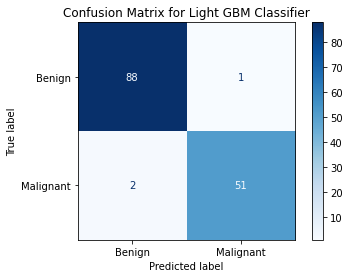

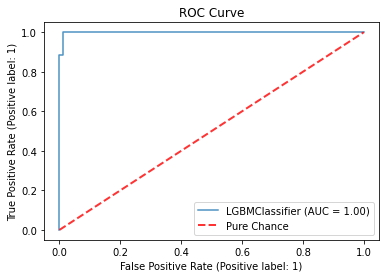

In [435]:
# Show the performance of Random Forest
show_confusion_matrix(optimal_lgbm, 'Light GBM Classifier', test_X, test_Y, lgbm_pred)
show_ROC_curve(optimal_lgbm, test_X, test_Y)

# Model 3: Try Baseline Logistic Regression with PCA

## Explore the number of principal components

In [436]:
minmaxscaler =  MinMaxScaler()

In [437]:
# Perform PCA on training data, keeping all components
pca = PCA()
pca.fit(minmaxscaler.fit_transform(train_X))

PCA()

In [438]:
# Show the ratio of variance explained by each component
exp_var = {}
for i in range(8):
    exp_var['PC'+str(i+1)] = pca.explained_variance_ratio_[i]
exp_var_df = pd.DataFrame(exp_var, index = ['explained_var_ratio'])
print(tabulate(exp_var_df, headers = 'keys', tablefmt='grid', stralign='center'))


+---------------------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+
|                     |      PC1 |      PC2 |       PC3 |      PC4 |       PC5 |       PC6 |       PC7 |       PC8 |
+=====================+==========+==========+===========+==========+===========+===========+===========+===========+
| explained_var_ratio | 0.535478 | 0.171391 | 0.0777178 | 0.062049 | 0.0392458 | 0.0279403 | 0.0168928 | 0.0115638 |
+---------------------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+


## Visualize PCA(2) on training set

In [439]:
# Convert features to (0, 1) scale for PCA
train_X_norm = minmaxscaler.fit_transform(train_X)
test_X_norm = minmaxscaler.transform(test_X)

In [440]:
# Perform PCA on training set and test set
pca = PCA(n_components = 2)
train_X_norm_reduced = pca.fit_transform(train_X_norm)
test_X_norm_reduced = pca.transform(test_X_norm)

In [441]:
# Visualize first 2 PCs together with the diagnosis result
train_X_pcs = pd.DataFrame(data = train_X_norm_reduced, columns = ['PC 1', 'PC 2'])
visual_pcs = pd.concat([train_X_pcs, train['diagnosis'].reset_index(drop = True)], axis = 1)

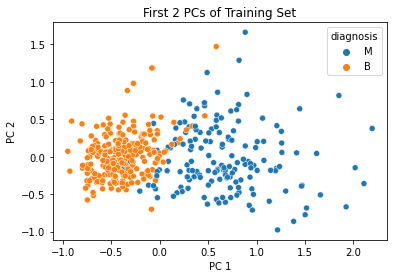

In [442]:
sns.scatterplot(data=visual_pcs, x='PC 1', y='PC 2', hue='diagnosis')
plt.title('First 2 PCs of Training Set')
plt.show()

## Perform PCA(2) + Logistic Regression

In [443]:
pca_lg = LogisticRegression(max_iter = 10000)
pca_lg.fit(train_X_norm_reduced, train_Y)
pca_lg_pred = pca_lg.predict(test_X_norm_reduced)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9366         |   1.0000    |   0.8302   |    1.0000     |
+---------+-----------------------+-------------+------------+---------------+


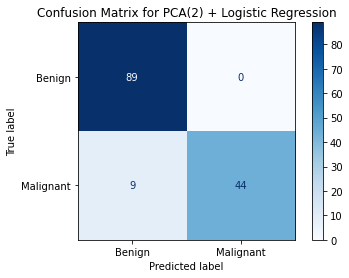

In [444]:
# Get confusion matrix
show_confusion_matrix(pca_lg, 'PCA(2) + Logistic Regression', test_X_norm_reduced, test_Y, pca_lg_pred)

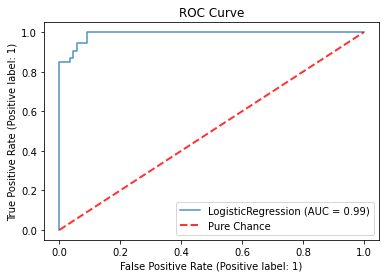

In [445]:
# Get ROC curve
show_ROC_curve(pca_lg, test_X_norm_reduced, test_Y)

## Perform PCA(4) + Logistic Regression

In [446]:
pca = PCA(n_components = 4)
train_X_norm_reduced = pca.fit_transform(train_X_norm)
test_X_norm_reduced = pca.transform(test_X_norm)

pca_lg = LogisticRegression(max_iter = 10000)
pca_lg.fit(train_X_norm_reduced, train_Y)
pca_lg_pred = pca_lg.predict(test_X_norm_reduced)


+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9577         |   0.9796    |   0.9057   |    0.9888     |
+---------+-----------------------+-------------+------------+---------------+


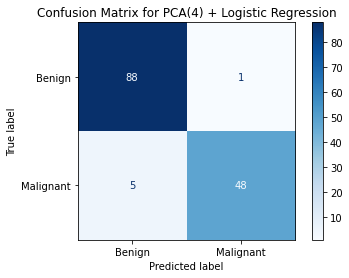

In [447]:
show_confusion_matrix(pca_lg, 'PCA(4) + Logistic Regression', test_X_norm_reduced, test_Y, pca_lg_pred)

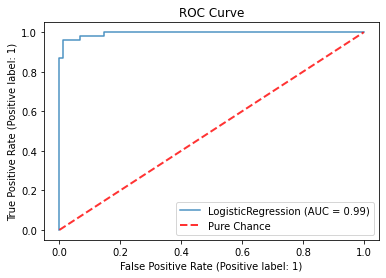

In [448]:
show_ROC_curve(pca_lg, test_X_norm_reduced, test_Y)